# Assignment 3: Use a single feature with different models

### Load full SVHN from HugginFace

In [179]:
# Import hugging face dataset
import huggingface_hub
from datasets import load_dataset

# Import cropped-digits dataset
dataset_cropped_digits_raw = load_dataset("ufldl-stanford/svhn",
                                          "cropped_digits",
                                          cache_dir='../data/svhn/')

In [180]:
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import cv2

from skimage import color, exposure, filters, util, morphology
from skimage import img_as_ubyte, img_as_float
from skimage.filters import rank
from skimage.filters import gaussian
from sklearn.preprocessing import FunctionTransformer

In [181]:
# Get dataset subsets
ds_train = dataset_cropped_digits_raw["train"]
ds_test = dataset_cropped_digits_raw["test"]

### Functions and pipeline

In [182]:
#def apply_gaussian_filter(image, sigma=6):
#    """
#    Apply a Gaussian filter to an image with stronger impact at the center
#    and diminishing effect on the left and right sides, without affecting top and bottom.
#    
#    Args:
#        image (numpy.ndarray): The input image to apply the filter to.
#        sigma (float): Standard deviation of the Gaussian filter (horizontal).
#
#    Returns:
#        numpy.ndarray: The filtered image scaled to the range [0, 255].
#        numpy.ndarray: The 2D Gaussian mask used for filtering.
#    """
#    # Get the image dimensions
#    height, width = image.shape
#    center_x = width / 2
#
#    # Create an array representing the horizontal distances from the center
#    x = np.arange(width)
#    
#    # Create the 1D Gaussian mask for horizontal distances (x-axis)
#    mask_x = np.exp(-((x - center_x) ** 2) / (2 * sigma ** 2))
#    
#    # Normalize the mask
#    mask_x /= mask_x.sum()
#
#    # Extend the 1D mask into a 2D mask (duplicate along the vertical axis)
#    mask = np.tile(mask_x, (height, 1))
#
#    # Mask out the first and last rows (top and bottom)
#    mask[0, :] = 0  # Set top row to zero
#    mask[-1, :] = 0  # Set bottom row to zero
#
#    # Apply the Gaussian mask to the image (element-wise multiplication)
#    masked_image = image * mask
#
#    # Scale the masked image to the range 0-255
#    masked_image_scaled = (masked_image - np.min(masked_image)) / (np.max(masked_image) - np.min(masked_image)) * 255
#    masked_image_scaled = masked_image_scaled.astype(np.uint8)
#
#    return masked_image_scaled, mask

def apply_gaussian_filter(image, sigma=6):
    # Create a Gaussian mask based on distance from the center
    height, width = image.shape
    y, x = np.ogrid[:height, :width]
    center_y, center_x = height / 2, width / 2

    # Create a Gaussian mask
    # sigma = Standard deviation for the Gaussian function
    mask = np.exp(-((x - center_x)**2 + (y - center_y)**2) / (2 * sigma**2))

    # Apply the Gaussian mask to the image
    masked_image = image * mask

    # Scale the masked image to 0-255
    masked_image_scaled = (masked_image - np.min(masked_image)) / (np.max(masked_image) - np.min(masked_image)) * 255
    masked_image_scaled = masked_image_scaled.astype(np.uint8)

    return masked_image_scaled, mask

def remove_borders(image, reduce_factor=0.1):
    # Define the border width as 10% of the image size
    border_size = int(32 * reduce_factor)

    blackout_image = image.copy()
    # Set the border regions to black (0)
    # Top border
    blackout_image[:border_size, :] = 0
    # Bottom border
    blackout_image[-border_size:, :] = 0
    # Left border
    blackout_image[:, :border_size] = 0
    # Right border
    blackout_image[:, -border_size:] = 0

    return blackout_image

def find_contours(image):
    # Find contours
    contours, _ = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    # Create a blank image to draw contours on
    contour_only_image = np.zeros_like(image)
    cv2.drawContours(contour_only_image, contours, -1, 255, 1)  # Draw contours in white (255)
    return contour_only_image

def sharpen_image(image, filter=(5,5)):
    # Sharpen image
    blurred = cv2.GaussianBlur(image, filter, 0)
    return cv2.addWeighted(image, 1.5, blurred, -0.5, 0)

def apply_median_filter(image):
    # Step 2: Reduce the impact of outliers using median filter
    selem = morphology.disk(2)
    return filters.rank.median(img_as_ubyte(image), selem)

def apply_log_filter(image):
    # Create a FunctionTransformer for the log transformation
    log_transformer = FunctionTransformer(np.log1p, validate=True)

    # Apply the log transformation
    transformed_image = log_transformer.fit_transform(image)

    # Rescale the transformed image back to [0, 255]
    transformed_image = (transformed_image / np.max(transformed_image)) * 255
    return transformed_image.astype(np.uint8)

In [183]:
def pipeline(ds,
             labels_ds,
             clahe_clipLimit=2.0,
             clahe_tileGridSize=(3,3),
             sharpen_filter=(5,5),
             gaussian_sigma=6,
             extra_filter=None,
             random_sample_id= None
             ):
    """ 
    Assumes input dataset are N samples of RGB images, 32x32 (32, 32, 3) shape.
    Input must be a np-array with images only.
    Transforms from RGB (3-channels) to a single grayscale channel
    Applies Gaussian weighting to remove distractions in borders
    Actual digit is centered

    Returns modified dataset
    """
    # Initialize an array to hold the grayscale images
    new_dataset = np.empty((len(ds), 32, 32), dtype=np.uint8)

    if random_sample_id is None:
        random_sample_id = random.randint(0, len(ds))
    original_random_image = ds[random_sample_id]
    original_random_label = labels_ds[random_sample_id]

    # Step 1: Convert images to grayscale
    gray_images = (color.rgb2gray(ds) * 255).astype(np.uint8)

    # Iterate per-image
    total_images_processed = 0
    for i in range(0, len(gray_images)):
        
        total_images_processed +=1
        gray_image = gray_images[i]

        # Sharpening
        sharpened_image = sharpen_image(gray_image, sharpen_filter)

        # CLAHE
        clahe = cv2.createCLAHE(clipLimit=clahe_clipLimit, tileGridSize=clahe_tileGridSize)
        clahe_image = clahe.apply(sharpened_image)

        # Median filter
        median_filtered_image = apply_median_filter(clahe_image)

        # Log filter
        log_filtered_image = apply_log_filter(clahe_image)

        image_for_binary = clahe_image
        if (extra_filter=="log"):
            image_for_binary = log_filtered_image
        if (extra_filter=="median"):
            image_for_binary = median_filtered_image

        # Use binary threshold to reduce everything to 2 colors
        _, binary_image = cv2.threshold(image_for_binary, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        #print(f'mean_binary: {np.mean(binary_image)}')

        # Get contours
        contour_image = find_contours(binary_image)

        # Gaussian filter
        masked_image_scaled, mask = apply_gaussian_filter(contour_image, gaussian_sigma)

        new_dataset[i] = masked_image_scaled

        # Log filter
        # log_filtered_image = apply_log_filter(median_filtered_image)

        if i == random_sample_id:
            # List of image data and titles for each row
            images = [
                (original_random_image, gray_image),       # Row 1 images
                (sharpened_image, clahe_image),             # Row 2 images
                (log_filtered_image, median_filtered_image),          # Row 3 images
                (binary_image, contour_image),                     # Row 4 images
                (mask, masked_image_scaled)                # Row 5 image (second image is None)
            ]

            # List of titles for each row
            titles = [
                ("Imagen Original", "Escala de Grises"),
                ("Sharpening", "CLAHE"),
                ("CLAHE + Log", "CLAHE + Median"),
                ("Binary Dynamic Threshold", "Contornos"),
                ("Máscara Gaussiana", "Imagen enmascarada")  # No second title for this row
            ]

            # Loop over the rows to create and save individual images for each row
            for i, (row_images, row_titles) in enumerate(zip(images, titles)):
                # Create a figure for the current row
                fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 images per row

                primer_paso = i*2
                segundo_paso = (i*2)+1
                #fig.suptitle(f'Pasos {primer_paso} y {segundo_paso}', fontsize=16)

                # Plot the first image in the row
                axes[0].imshow(row_images[0], cmap='gray')
                axes[0].set_title(row_titles[0])
                axes[0].axis('off')

                # If there is a second image, plot it
                if row_images[1] is not None:
                    axes[1].imshow(row_images[1], cmap='gray')
                    axes[1].set_title(row_titles[1])
                    axes[1].axis('off')
                else:
                    axes[1].axis('off')  # Hide the second axis if no second image

                # Save the image for the current row
                plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Adjust spacing if necessary

                plt.savefig(f'row_{i+1}_images.png', dpi=300, bbox_inches='tight')  # Save each row's image
                #plt.close()  # Close the figure to free up memory

    return new_dataset

#### Simple testing

In [184]:
#Interesting: 3, 5, 13, 1082, 1300, 21490, 28689, 26051, 28689, 41470, 10374

index = 10374
image = np.array(ds_train[index]["image"])

In [185]:
# Hyperparameters


#def pipeline(ds,
#             labels_ds,
#             clahe_clipLimit=2.0,
#             clahe_tileGridSize=(3,3),
#             sharpen_filter=(5,5),
#             gaussian_sigma=6,
#             extra_filter=None,
#             random_sample_id= None
#             ):

clahe_clipLimit = 2
clahe_tileGridSize = (1,1)
sharpen_filter = (5,5)
gaussian_sigma = 6
extra_filter = None

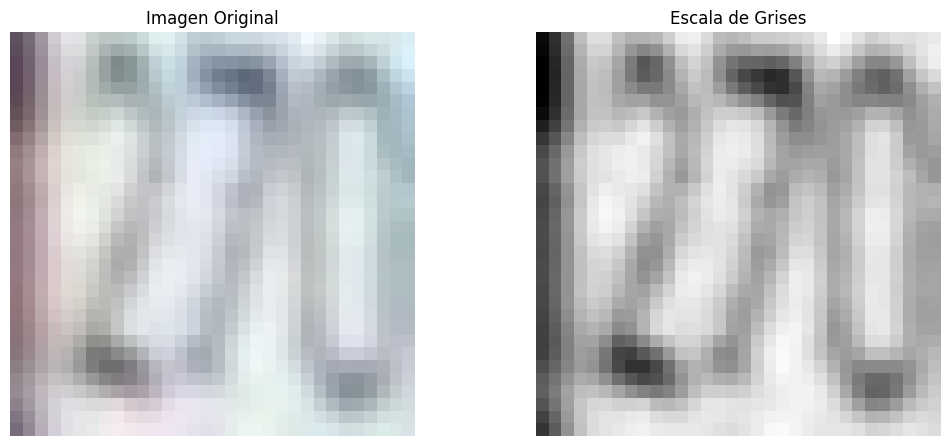

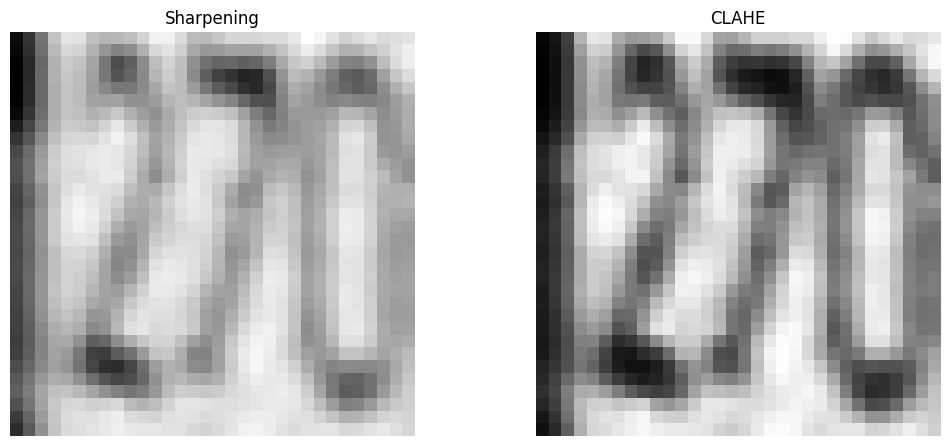

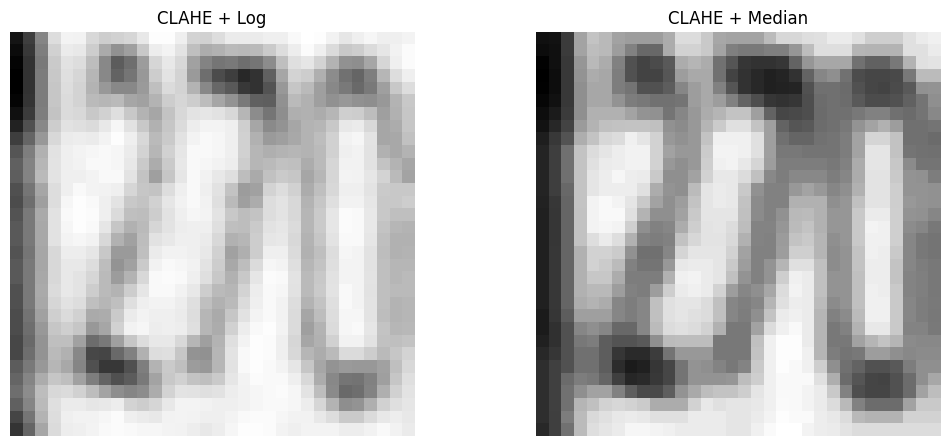

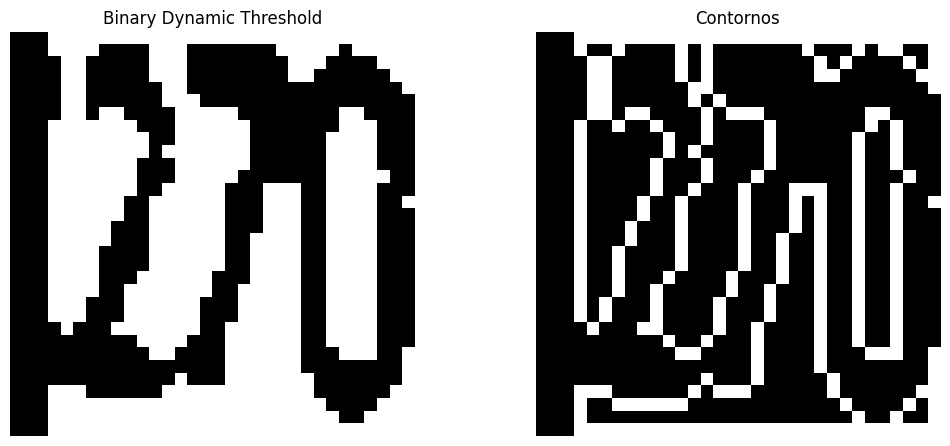

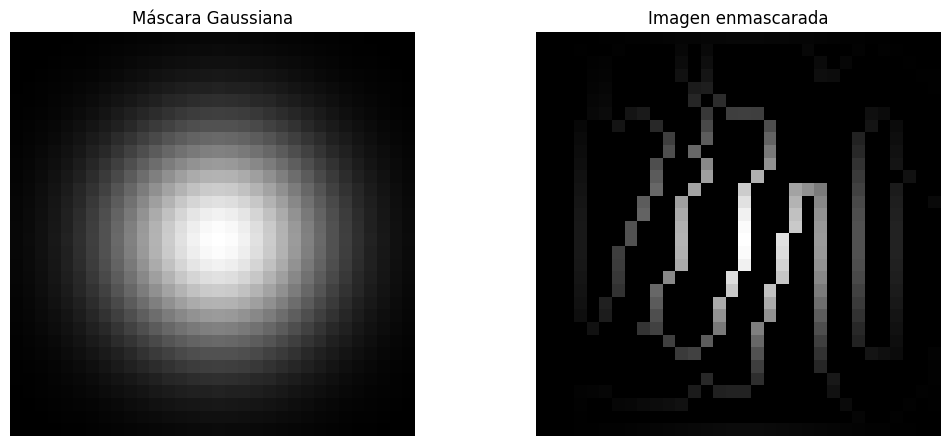

In [186]:
test = pipeline(np.expand_dims(image, axis=0),
                ds_train["label"],
                clahe_clipLimit=clahe_clipLimit,
                clahe_tileGridSize=clahe_tileGridSize,
                sharpen_filter=sharpen_filter,
                gaussian_sigma=gaussian_sigma,
                extra_filter=extra_filter,
                random_sample_id=0)

## Get X_train, X_test datasets with our processing

(73257, 1024)


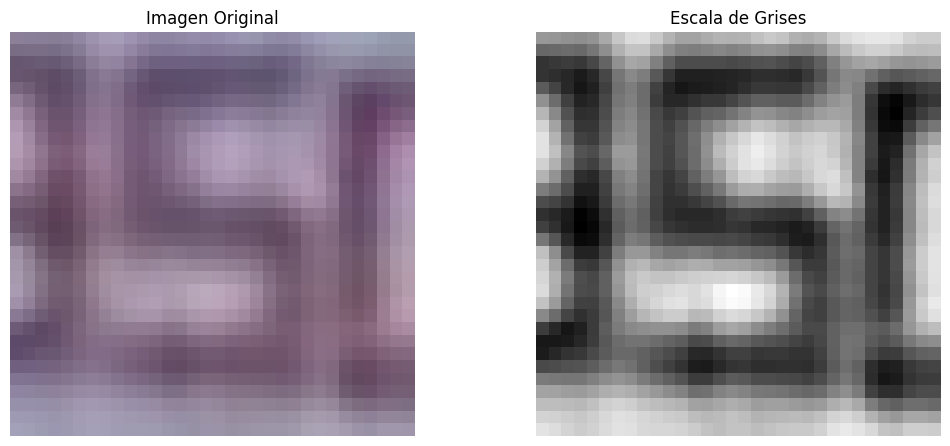

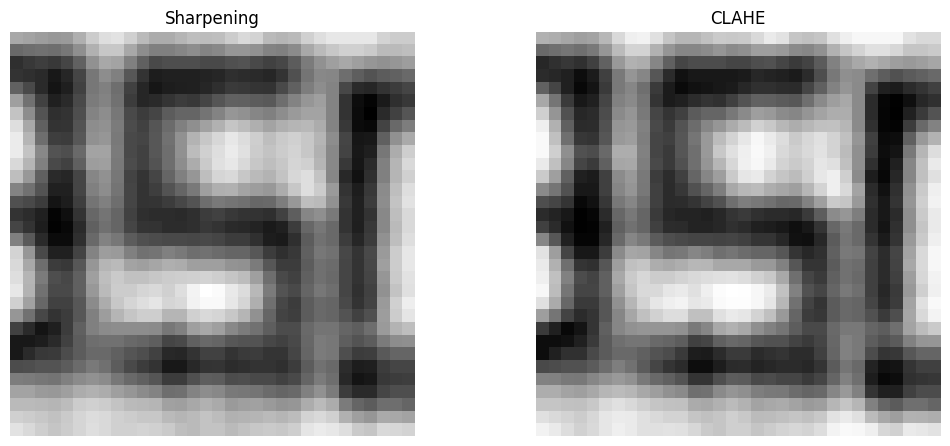

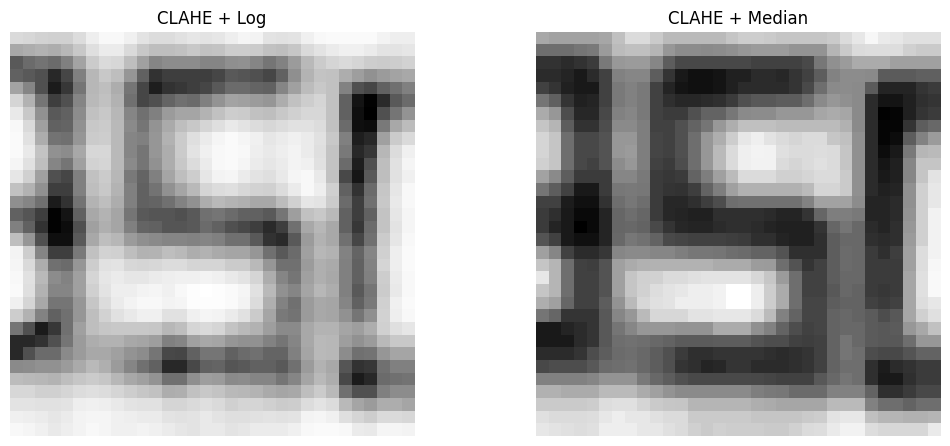

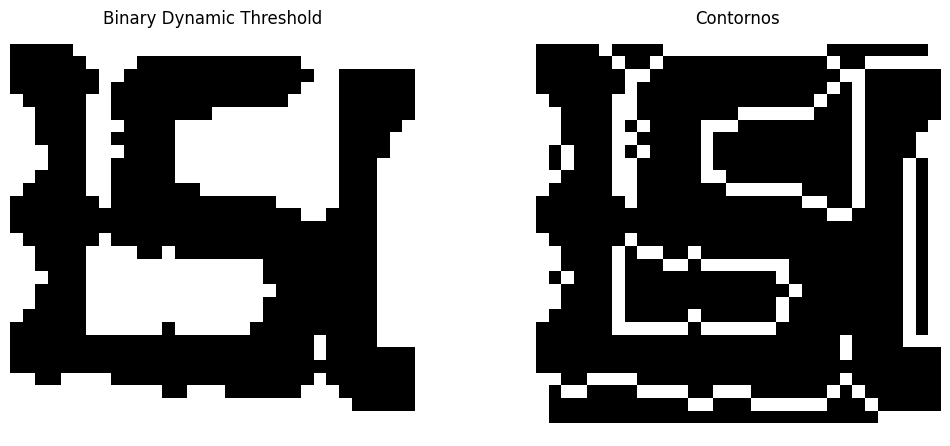

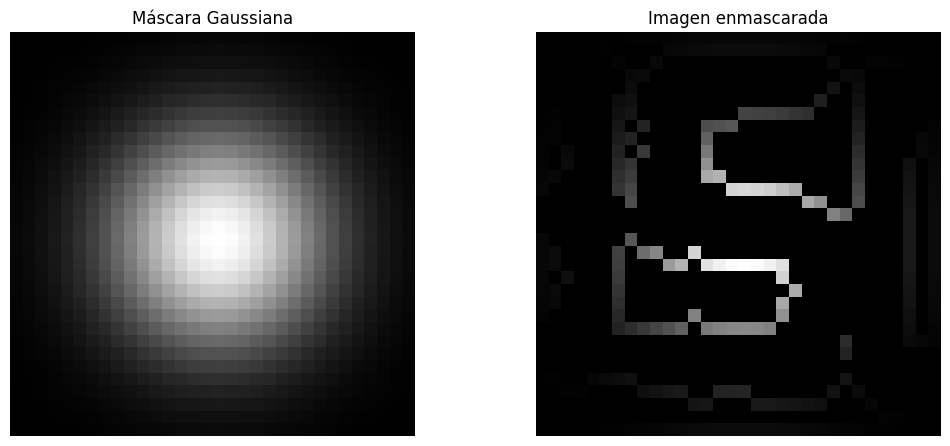

In [187]:
# X_train

ds_train_images = np.array(ds_train["image"])
X_train = pipeline(ds_train_images,
                   ds_train["label"],
                   clahe_clipLimit=clahe_clipLimit,
                   clahe_tileGridSize=clahe_tileGridSize,
                   sharpen_filter=sharpen_filter,
                   gaussian_sigma=gaussian_sigma,
                   extra_filter=extra_filter
                   )
Y_train = ds_train["label"]

X_train = X_train.reshape(X_train.shape[0], -1)

print(X_train.shape)

(26032, 1024)


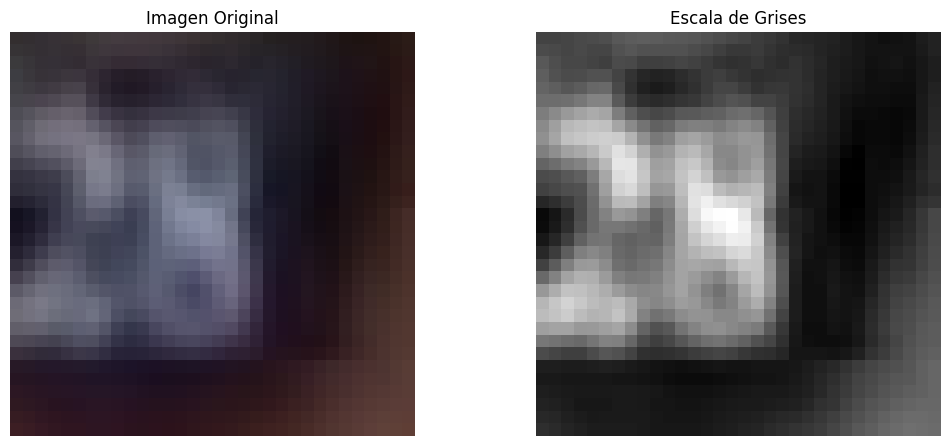

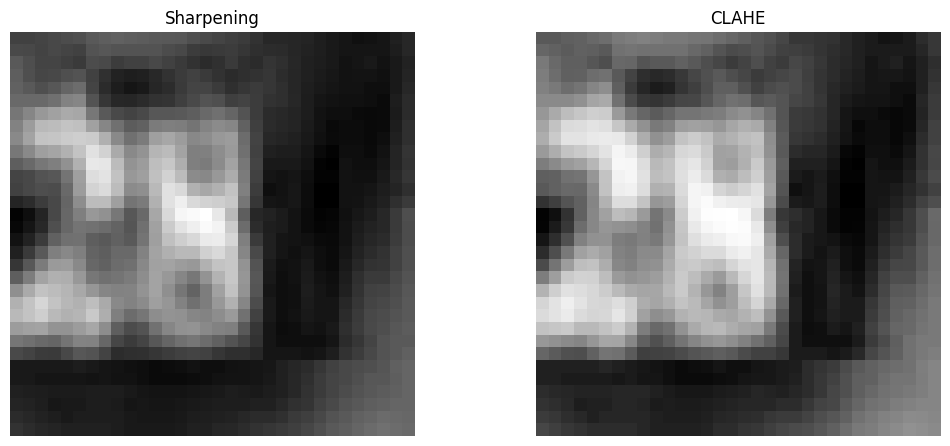

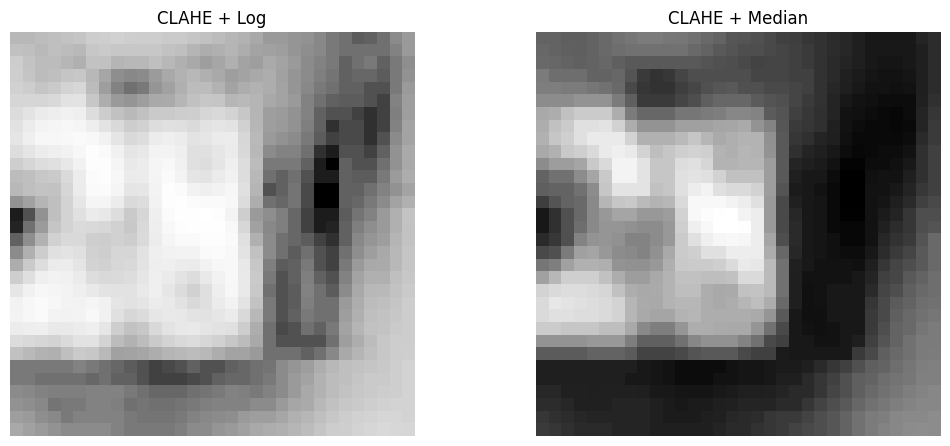

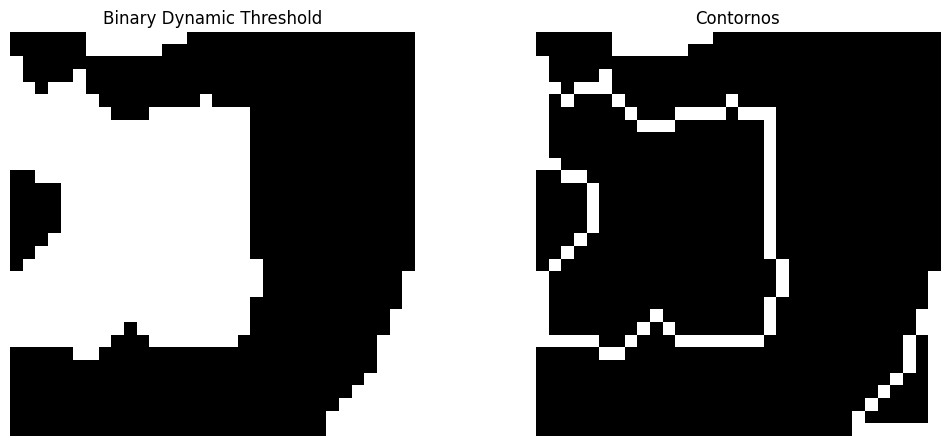

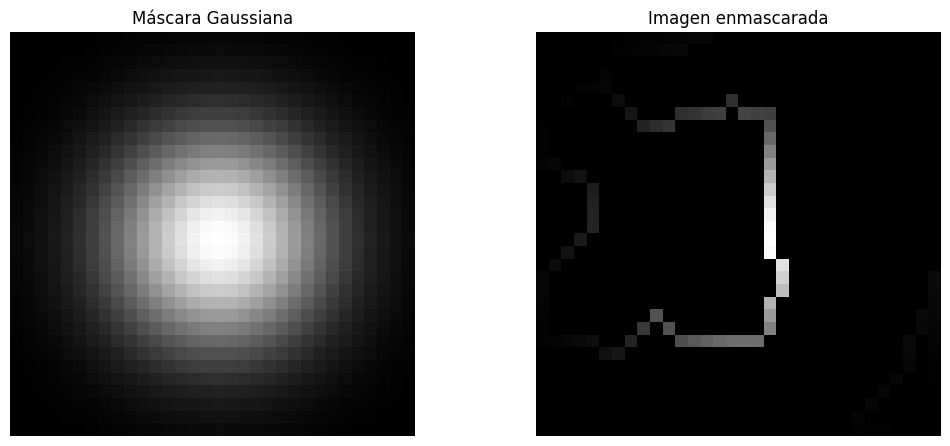

In [188]:
# X_test

ds_test_images = np.array(ds_test["image"])
X_test = pipeline(ds_test_images,
                  ds_test["label"],
                  clahe_clipLimit=clahe_clipLimit,
                  clahe_tileGridSize=clahe_tileGridSize,
                  sharpen_filter=sharpen_filter,
                  gaussian_sigma=gaussian_sigma,
                  extra_filter=extra_filter
                 )
Y_test = ds_test["label"]

X_test = X_test.reshape(X_test.shape[0], -1)

print(X_test.shape)

## Use PCA

In [211]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

gray_train = (color.rgb2gray(ds_train_images) * 255).astype(np.uint8)
gray_test = (color.rgb2gray(ds_test_images) * 255).astype(np.uint8)

X_pca_train = gray_train.reshape(gray_train.shape[0], -1)
X_pca_test = gray_test.reshape(gray_test.shape[0], -1)

#X_pca_train = pca.fit_transform(X_pca_train)
#X_pca_test = pca.fit_transform(X_pca_test)
#X_pca_train.shape
#

In [212]:
#plt.scatter(X_pca_train[:, 0], X_pca_train[:, 1], c=np.array(ds_train["label"]), cmap='RdYlBu')
#plt.colorbar()
#plt.savefig(f'pca.png', dpi=300, bbox_inches='tight')  # Save each row's image

### Run with SKLEARN LogisticRegression

In [208]:
## Use SGDC for clasification
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
#
#model = SGDClassifier(alpha=0.001, max_iter=1000)
#model.fit(X_train, Y_train)
#
#y_pred = model.predict(X_test)
#
#accuracy = accuracy_score(Y_test, y_pred)
#print(f"Accuracy: {accuracy:.4f}")

### Run with cross validation

In [213]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

# Use support Vector Classifier SVC

knn_range = list(range(1, 30))
pca_range = list(range(1, 30))

knn_pipeline = Pipeline(
    steps=[
        ('pca', PCA()),
        ('knn', KNeighborsClassifier())
    ])

sgd_pipeline = Pipeline(
    steps=[
        ('pca', PCA()),
        ('sgd', SGDClassifier())
    ])

parameters = {
    'pca__n_components' : pca_range,
    'knn__n_neighbors'  : knn_range
}

gridsearch = GridSearchCV(knn_pipeline,
                          parameters,
                          cv=5,
                          scoring='accuracy',
                          return_train_score=False
                         )

gridsearch.fit(X_pca_train, Y_train)

KeyboardInterrupt: 

In [204]:
best_params = gridsearch.best_params_
best_params

{'alpha': 0.001, 'loss': 'log_loss', 'max_iter': 1000}

In [210]:
model = SGDClassifier(alpha=best_params['alpha'],
                      max_iter=best_params['max_iter'],
                      loss=best_params['loss'])

model.fit(X_pca_train, Y_train)
model.score(X_pca_test, Y_test)

0.1604179471419791

In [ ]:
#from sklearn.linear_model import LogisticRegression
#
#log_reg = LogisticRegression(max_iter=1000)
#
#log_reg.fit(X_train, Y_train)
#
#y_pred = log_reg.predict(X_test)
#
#accuracy = accuracy_score(Y_test, y_pred)
#print(f"Accuracy: {accuracy:.4f}")